In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anthro.viz
colors = anthro.viz.plotting_style()
plt.rcParams["font.family"] = "Lucida Sans Unicode"

In [2]:
#%% Load the population data 
pop_data = pd.read_csv('../../../data/anthropocentric/FAOSTAT_world_population/processed/FAOSTAT_rural_urban_population.csv')
pop_data['pop_bil'] = pop_data['population'] / 1E9
total_pop = pop_data.groupby(['year'])['pop_bil'].sum().reset_index()
min_pop, max_pop = total_pop['pop_bil'].min(), total_pop['pop_bil'].max()

In [3]:
# Generate plots for greenhouse gas emissions from EDGARv6.0 data
sources = ['CH4']
# Read uncertainties from Janssens-Maenhout et al (2019)
unc_data = pd.read_csv('../../../data/atmosphere_biogeochemistry/EDGAR_GHG_emissions/processed/uncertainty_emissions_Janssens_Maenhout.csv')

for source_ in sources:
    data = pd.read_csv('../../../data/atmosphere_biogeochemistry/EDGAR_GHG_emissions/processed/'+str(source_)+'_emissions_processed.csv')
    data['year'] = pd.to_datetime(data['Year'].astype(str), format='%Y', errors='coerce')
    agg_data = pd.DataFrame()
    agg_data['year'] = (data[data['C_group_IM24_sh']=='World'])['year']
    agg_data['emissions'] = np.round( (data[data['C_group_IM24_sh']=='World'])['Emissions (Gg)']/1000.0, 1)
    # Construct uncertainty from relative uncertainty based on Janssens-Maenhout et al (2019), EDGARv4.3.2
    # Rthe uncertainty bands are given by [base*(1-2_sigma), base*(1+2_sigma)].
    agg_data['relative std'] = ((unc_data[unc_data['Greenhouse Gas'].str.contains(source_)])['Relative uncertainty, 2 std']
            ).to_numpy()
    agg_data['lower bound'] = np.multiply( agg_data['emissions'], 1 - agg_data['relative std'] )
    agg_data['upper bound'] = np.multiply( agg_data['emissions'], 1 + agg_data['relative std'] )
years = np.arange(1970, 2019)
agg_data['year'] = years
merged = agg_data.merge(total_pop, on='year')

In [4]:
decades = [1970, 1980, 1990, 2000, 2010, 2020]
ch4_decades = np.zeros(5)


for i in range(len(decades)-1):
    
    decade = decades[i]
    
    df_decade = merged[merged['year']>= decade]
    df_decade = merged[merged['year']< decades[i+1]]
    
    pop_decade = df_decade['pop_bil'].mean()
    ch4_decade = df_decade['emissions'].mean() / pop_decade
    
    ch4_decades[i] = ch4_decade

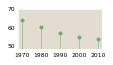

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(1.5,0.75))

ax.xaxis.set_tick_params(labelsize=6)
ax.yaxis.set_tick_params(labelsize=6)
#ax.set_ylabel('per capita [m$^{3}$]', fontsize=6)
ax.set_xticks((1970, 1980, 1990, 2000, 2010))
#ax.set_yticks((0, 5, 10))
ax.set_ylim((np.min(ch4_decades)*0.9,np.max(ch4_decades)*1.1))

ax.plot(decades[0:-1], ch4_decades, 'o', ms=3, color=colors['green'])
ax.vlines(decades[0:-1], 0, ch4_decades, lw=0.5, color=colors['green'])

plt.savefig('../../../figures/database_paper/ch4_emissions_decades.svg')

In [7]:
plt.rcParams["font.family"] = "Lucida Sans Unicode"